We want to find out A of wave equation


$$\frac{1}{v^2} \frac{\delta^2 y}{\delta t^2}- \frac{\delta ^2}{\delta x^2}= 0$$

In [19]:

import numpy as np
import matplotlib.pyplot as plt
from IPython import display
from math import exp
import functools

import torch 
from torch import nn, optim
from torch.nn import functional as F

from sklearn.model_selection import train_test_split

from softadapt import LossWeightedSoftAdapt


In [33]:

def wave_function(x, t, k=1, A=1, v=2):
    """
    Compute the wave function y(x, t) = A * sin(k*x - v*t).
    
    Parameters:
    - x: Array of x values.
    - t: Time parameter.
    - k: Wave number (default is 1).
    - A: Amplitude (default is 1).
    - v: Velocity (default is 2).
    
    Returns:
    - Array of y values.
    """

    return A * np.sin(k*x - v*t)

# Define the domain
L = 10  # Length of the spatial domain
T = 5   # Time duration
num_samples = 1000  # Number of samples

# Generate random sample points
x_samples = np.random.uniform(0, L, num_samples)
t_samples = np.random.uniform(0, T, num_samples)

# Compute the wave function values (assuming a known solution)
# For demonstration, let's use a simple sinusoidal wave solution
# u(x, t) = A * sin(k * x - omega * t)
k = 1       # Wave number
A = 1       # Amplitude
v = 2       # Angular frequency

# Feature-set
features = np.column_stack((x_samples, t_samples))
# u_samples = A * np.sin(k * x_samples - omega * t_samples)
targets = wave_function(x_samples, t_samples, k, A, v)


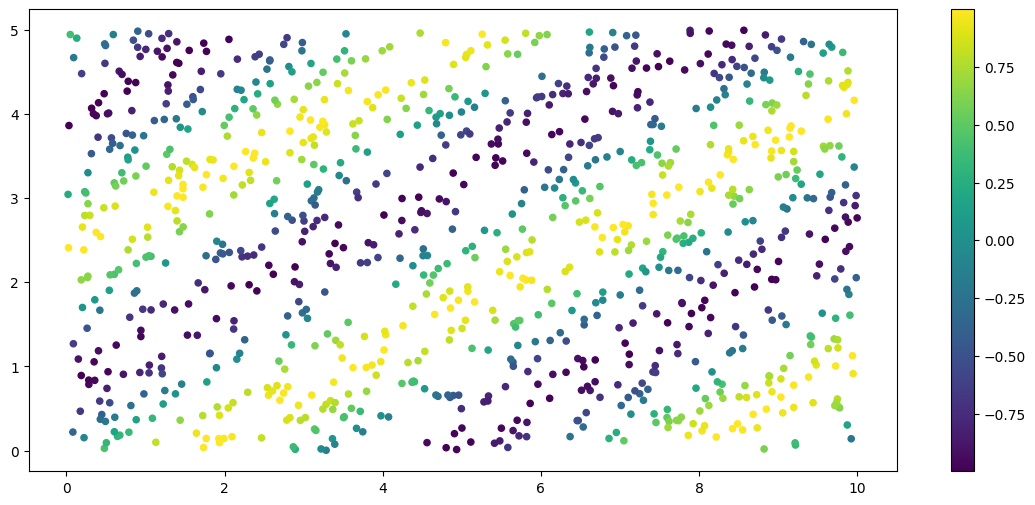

In [34]:

plt.figure(figsize=(14, 6), dpi=100)
plt.scatter(features[:, 0], features[:, 1], c=targets, s=20, cmap='viridis')
plt.colorbar()


In [14]:

def u(x,t,A,v): return A*np.sin(x - v*t)

def u_diff_diff_tt(x,t,v,A): return A*(v**2)*np.sin(-x - v*t)

def u_diff_diff_xx(x,t,v,A): return A*np.sin(-x - v*t)



In [15]:
class Net(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim=64, n_layers=2):
        
        super(Net, self).__init__()
        
        # model discovery parameters
        #self.A = nn.Parameter(data=torch.tensor(0.), requires_grad=True) # rate of temp change. Init=0.
        
        activation = nn.Softplus # nn.LeakyReLU, nn.Tanh, nn.ReLU, nn.ELU

        self.input = nn.Sequential(
            nn.Linear(input_dim, hidden_dim), 
            activation()
        )
        
        self.network = nn.Sequential(
            *[nn.Sequential(
                nn.Linear(hidden_dim, hidden_dim),
                activation()
            ) for i in range(n_layers)]
        )

        self.output = nn.Sequential(
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        x = self.input(x)
        x = self.network(x)
        x = self.output(x)
        return x


In [16]:
def gradient(outputs, inputs, order=1):
    """
    Computes the partial derivative of 
    an output with respect to an input.
    Given an order, we compute the gradient multiple times.
    """
    grads = []
    for i in range(order):
        grads.append(torch.autograd.grad(outputs, inputs, grad_outputs=torch.ones_like(outputs), create_graph=True)[0])
        outputs = grads[-1]
    
    return outputs, grads



In [20]:
A, v = 2, 4

def u(x,t): return A*np.sin(x - v*t)

def u_diff_diff_tt(x,t): return A*(v**2)*np.sin(-x - v*t)

def u_diff_diff_xx(x,t): return A*np.sin(-x - v*t)

def pde(x, t, v):
    return 1/(v**2) *u_diff_diff_tt(x,t) - u_diff_diff_xx(x,t)

def pde_loss(model: nn.Module, coll_points):
    """
    1/v^2 * u_tt - u_xx = 0
    """
 
    L = 10  # Length of the spatial domain
    T = 5   # Time duration
    num_samples = 1000  # Number of samples

    # Generate random sample points
    x_s = np.random.uniform(0.0, L, coll_points)
    t_s = np.random.uniform(0.0, T, coll_points)

    x_s_ = torch.tensor(x_s, dtype = torch.float).requires_grad_(True)
    t_s_ = torch.tensor(t_s, dtype = torch.float).requires_grad_(True)

    input1_ = torch.column_stack((x_s_, t_s_)).reshape(-1, 2).requires_grad_(True)
    Wave = model(input1_)

    #compute the gradients
    u_tt,_ = gradient(Wave, x_s_, order=2)
    u_xx,_ = gradient(Wave, t_s_, order=2)

    #compute the loss
    model_pde = (1/(v**2) * u_tt - u_xx)
    loss = torch.mean((model_pde - 0)**2)

    return loss




In [21]:
print(np.shape(features))

(1000, 2)


In [22]:
features_ = torch.tensor(features).float().reshape(-1, 2).requires_grad_(True)
targets_ = torch.tensor(targets).float().reshape(-1, 1).requires_grad_(True)

print(features_.shape)
print(targets_.shape)

torch.Size([1000, 2])
torch.Size([1000, 1])


In [ ]:
# plotting params
plt.rcParams['contour.negative_linestyle'] = 


In [50]:
z.max()

3.9987693635444472

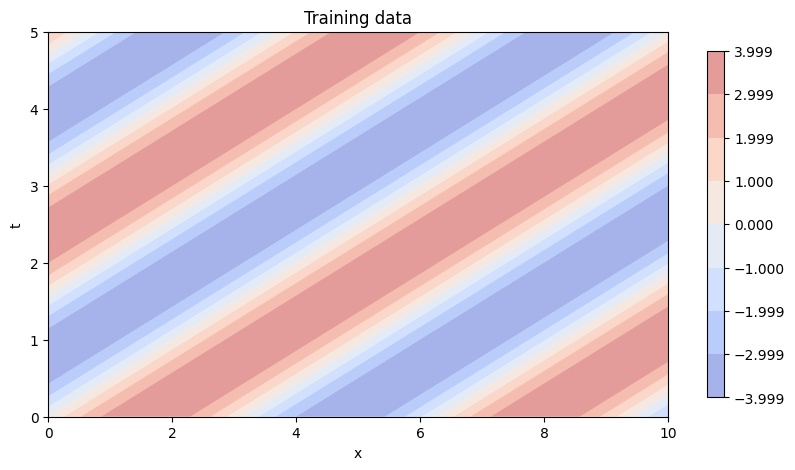

In [125]:
x_grid = np.linspace(0, L, 100)
t_grid = np.linspace(0, T, 100)
x, t = np.meshgrid(x_grid, t_grid)
z = wave_function(x, t, A=4)

levels = np.linspace(z.min(), z.max(), 9)
# level_colors = ['blue', 'red', 'black']

fig, ax = plt.subplots(figsize=(10, 5), dpi=100)
CS_train = ax.contourf(x, t, z, levels=levels, cmap='coolwarm', alpha=0.5, antialiased=True) #hatches=['-','\\'], extend='both')
fig.colorbar(CS_train, ax=ax, shrink=0.9)
# ax.clabel(CS_train, inline=1, fontsize=10)
ax.set_title('Training data')
ax.set_xlabel('x')
ax.set_ylabel('t')

plt.show()

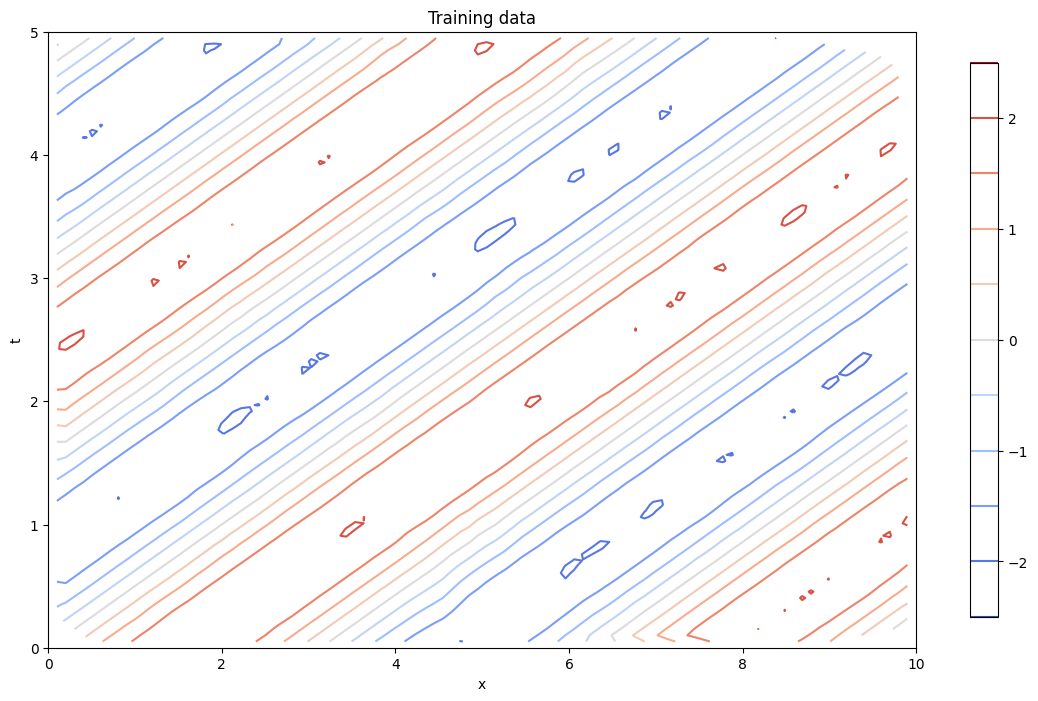

In [137]:
# Simplest plot, where we can easily see the comparison between the true and predicted values
from scipy.interpolate import griddata

z_samples = wave_function(x_samples, t_samples, A=2)

x_grid = np.linspace(0, L, 100)
t_grid = np.linspace(0, T, 100)
x, t = np.meshgrid(x_grid, t_grid)

z = griddata((x_samples, t_samples), z_samples, (x, t), method='cubic')

levels = np.linspace(z_samples.min(), z_samples.max(), 9)
# level_colors = ['blue', 'red', 'black']

fig, ax = plt.subplots(figsize=(14, 8), dpi=100)
contour = ax.contour(x, t, z, levels=9, cmap='coolwarm')
fig.colorbar(contour, ax=ax, shrink=0.9)
ax.set_title('Training data')
ax.set_xlabel('x')
ax.set_ylabel('t')

plt.show()

In [153]:
# find non-nan values of z
#idx = np.argwhere(np.isnan(z))
np.isnan(z).sum() - z.flatten().shape[0]

-9545

C:\Users\Simon\AppData\Local\Temp\ipykernel_25404\1900183276.py:18: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  ax.legend([CS_positive.collections[0], CS_negative.collections[0], CS_zero.collections[0]],


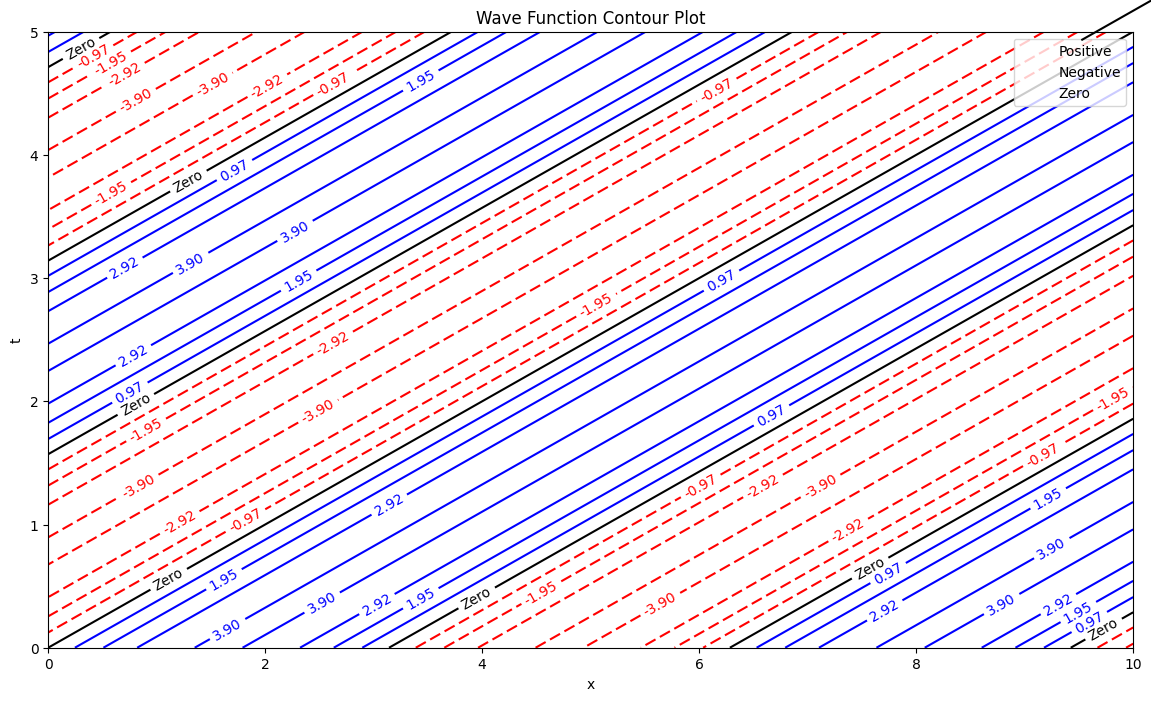

In [83]:
epsilon = 0.1  # Buffer for plot margins
levels_positive = np.linspace(0, z.max() - epsilon, 5)[1:]  # Positive levels
levels_negative = np.linspace(z.min() + epsilon, 0, 5)[:-1]  # Negative levels
levels_zero = [0]  # Zero level

fig, ax = plt.subplots(figsize=(14, 8), dpi=100)
# Create separate contour plots for each set of levels
CS_positive = ax.contour(x, t, z, levels=levels_positive, colors='blue')
CS_negative = ax.contour(x, t, z, levels=levels_negative, colors='red')
CS_zero = ax.contour(x, t, z, levels=levels_zero, colors='black')

# Add labels to the contours
ax.clabel(CS_positive, inline=1, fontsize=10, fmt='%2.2f')
ax.clabel(CS_negative, inline=1, fontsize=10, fmt='%2.2f')
ax.clabel(CS_zero, inline=1, fontsize=10, fmt={0: 'Zero'})

ax.set_title('Wave Function Contour Plot')
ax.set_xlabel('x')
ax.set_ylabel('t')
# ax.legend(['Positive', 'Negative', 'Zero'])

plt.show()

In [27]:
# defining model
pinn = Net(input_dim=2, output_dim=1, hidden_dim=16, n_layers=3)
criterion = nn.MSELoss()
optimizer = optim.Adam(pinn.parameters(), lr=1e-4, weight_decay=1e-5)


### SoftAdapt parameters
# Change 1: Create a SoftAdapt object (with your desired variant)
softadapt_object = LossWeightedSoftAdapt(beta=0.5)

# Change 2: Define how often SoftAdapt calculate weights for the loss components
epochs_to_make_updates = 5

# Change 3: Initialize lists to keep track of loss values over the epochs we defined above
values_of_component_1 = []
values_of_component_2 = []

# Initializing adaptive weights to all ones.
adapt_weights = torch.tensor([1,1])




### training loop
epochs = 10000

# Prepare the plot
fig, ax = plt.subplots(figsize=(10, 10), nrows=5)

losses = np.zeros(epochs)
losses_data = np.zeros(epochs)
losses_physics = np.zeros(epochs)

lambda_data = np.zeros(epochs)
lambda_physics = np.zeros(epochs)

epochs_x = np.arange(epochs)

verbose = True
pinn.train()

for epoch in range(epochs):
    optimizer.zero_grad()
    wave_pred = pinn(features_) #features skal have to coloumns

    # regular data driven loss
    loss_data = criterion(wave_pred, targets_)

    # ODE physics loss
    loss_physics = pde_loss(pinn, coll_points=1000)

    
    values_of_component_1.append(loss_data)
    values_of_component_2.append(loss_physics)
    
    # Change 4: Make sure `epochs_to_make_change` have passed before calling SoftAdapt.
    if epoch % epochs_to_make_updates == 0 and epoch != 0:
        adapt_weights = softadapt_object.get_component_weights(torch.tensor(values_of_component_1), 
                                                                torch.tensor(values_of_component_2),
                                                                verbose=False,
                                                                )
                                
        # Resetting the lists to start fresh (this part is optional)
        values_of_component_1 = []
        values_of_component_2 = []
    
    # Change 5: Update the loss function with the linear combination of all components.
    loss = adapt_weights[0] * loss_data + adapt_weights[1]*loss_physics
    

    loss.backward()                 # Backward pass: Compute gradient of the loss with respect to model parameters
    optimizer.step()                # Update weights
    
    # logging
    losses_data[epoch] = loss_data.item()
    losses_physics[epoch] = loss_physics.item()
    losses[epoch] = loss.item()

    lambda_data[epoch] = adapt_weights[0].detach().numpy()
    lambda_physics[epoch] = adapt_weights[1].detach().numpy()
    
    print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item()}') if epoch % 999 == 0 and epoch != 0 else None


    ep_plot = 500
    if epoch % ep_plot == 0 and epoch != 0 and verbose:
        print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item()}')

        # Plotting the loss
        a = 0.3
        ax[0].plot(epochs_x[:epoch], losses_data[:epoch], 'b', alpha=a, label='Data Loss')
        ax[0].plot(epochs_x[:epoch], losses_physics[:epoch], 'r', alpha=a, label='Physics Loss')
        # ax[0].plot(epochs_x[:epoch], losses_ic[:epoch], 'g', alpha=a, label='IC Loss')
        ax[0].plot(epochs_x[:epoch], losses[:epoch], 'black', alpha=a, label='Total Loss')
        ax[0].set_xlabel('Epochs')
        ax[0].set_ylabel('Loss')
        ax[0].set_title('Component losses')
        ax[0].set_xlim(0, epochs)
        ax[0].set_yscale("log")

        ### Plotting the weights
        ax[1].plot(epochs_x[:epoch], lambda_data[:epoch], c='b', label='Data weight')
        ax[1].plot(epochs_x[:epoch], lambda_physics[:epoch], c='r', label='Physics weight')
        # ax[1].plot(epochs_x[:epoch], lambda_ic[:epoch], c='g', label='IC weight')
        ax[1].set_xlabel('Epochs')
        ax[1].set_ylabel('$\lambda$')
        ax[1].set_title('Component weights')
        ax[1].set_xlim(0, epochs)
        
        # ### Plotting a parameter
        # ax[2].plot(epochs_x[:epoch], rs[:epoch], 'black', label='Dissipation rate')
        # ax[2].axhline(y=R, c='r', label='True dissipation rate')
        # ax[2].set_xlabel('Epochs')
        # ax[2].set_ylabel('Dissipation rate')
        # ax[2].set_title('Dissipation rate')
        # ax[2].set_xlim(0, epochs)


        # ### Plotting the function
        # full_T_pred = pinn(torch.tensor(times).float().reshape(-1, 1)).detach().numpy()
        # ax[3].plot(times, temps, 'black', label='Ground Truth')
        # ax[3].scatter(t, T,c='blue', label='Training observations')
        # ax[3].plot(times, full_T_pred, 'red', alpha=0.1, label='Prediction')
        # ax[3].set_xlabel('time t')
        # ax[3].set_ylabel('T(t)')
        # ax[3].set_title(f'Prediction for epoch {epoch+1}/{epochs}')
        # ax[3].set_ylim(10, 110)

        # ### Plotting the contours
        # fig_cont, axs_cont = plt.subplots(figsize=(14, 8), dpi=100)
        CS_train = ax.contour(features[0], features[0], targets_train.reshape(xx_train.shape), colors='black')
        CS_train_pred = ax.contour(xx_train, yy_train, targets_train_pred.reshape(xx_train.shape), colors='green')
        # test comparisons
        # CS_test = ax.contour(xx_test, yy_test, targets_test.reshape(xx_test.shape), colors='blue')
        # CS_test_pred = ax.contour(xx_test, yy_test, targets_test_pred.reshape(xx_test.shape), colors='red')
        ax.clabel(CS_train, inline=1, fontsize=10)
        ax.clabel(CS_train_pred, inline=1, fontsize=10)


        # add legend to all axes
        if epoch < ep_plot+1:
            for i in range(4):
                ax[i].legend()

        plt.tight_layout()
        display.clear_output(wait=True)
        display.display(fig)
        
        # Pause a bit so that the plot updates
        plt.pause(0.1)

KeyboardInterrupt: 

<Figure size 640x480 with 0 Axes>